In [1]:
# Usual imports
import secml
import numpy as np
from tqdm import tqdm
from scipy.special import softmax
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from joblib import Parallel, delayed
import pickle
import os
import pandas as pd
import csv
import random
import seaborn as sns

# SecML
from secml.ml.features.normalization import CNormalizerMinMax
from secml.ml.peval.metrics import CMetricAccuracy
from secml.array import CArray
from secml.data import CDataset
from secml.ml.classifiers import CClassifierPyTorch

# RobustBench
import robustbench
from robustbench.utils import load_model
from secml.utils import fm
from secml import settings

# Albi utils
from utils_attacks import *
from utils_CP_tiny import *
from utils_train_tinyimagenet import *

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torchvision.datasets as datasets


2025-04-16 22:09:42.283726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 22:09:42.432847: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 22:09:42.438091: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/torch/lib:/usr/local/lib/python3.10/dist-pa

2025-04-16 22:09:49,423 - py.warnings - WARNING - /usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Terminal width: 80


## Dataset

In [2]:
# Path to the Tiny ImageNet dataset
#data_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/tiny-imagenet-200/"

# Define transformations (resize and normalize)
#transform = transforms.Compose([
#        transforms.ToTensor(),
#        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#    ])

# Load train and validation sets using ImageFolder
#train_dataset = datasets.ImageFolder(root=data_path + "val", transform=transform)
#learning_dataset = datasets.ImageFolder(root=data_path + "train", transform=transform)

# Path to the Tiny ImageNet dataset
data_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/tiny-imagenet-200/"

# Define transformations (resize and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full training dataset
full_dataset = datasets.ImageFolder(root=data_path + "train", transform=transform)

# Select a random subset of 10,000 samples
num_samples = 10000
subset_indices = random.sample(range(len(full_dataset)), num_samples)
subset_dataset = Subset(full_dataset, subset_indices)

learning_dataset = subset_dataset

#X_train = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
#y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

X_learning = np.array([learning_dataset[i][0].numpy() for i in range(len(learning_dataset))])
y_learning = np.array([learning_dataset[i][1] for i in range(len(learning_dataset))])

#print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  
print(f"X_learning shape: {X_learning.shape}, y_learning shape: {y_learning.shape}")  

# Convert NumPy arrays to CArray
X_learning_carray = CArray(X_learning.reshape(X_learning.shape[0], -1))  # Flatten images
y_learning_carray = CArray(y_learning)

# Create the CDataset
lr = CDataset(X_learning_carray, y_learning_carray)

# Print dataset summary
print("CDataset:", lr)

# Shuffle before splitting
random_state = 999
rng = np.random.default_rng(seed=random_state)
shuffled_indices = rng.permutation(lr.X.shape[0]).tolist()
lr = lr[shuffled_indices, :]

X_learning shape: (10000, 3, 64, 64), y_learning shape: (10000,)
CDataset: CDataset{'X': CArray(10000, 12288)(dense: [[-0.098039 -0.098039 -0.098039 ... -0.458824 -0.419608 -0.231373] [-0.945098 -0.937255 -0.945098 ...  0.568627  0.568627  0.568627] [ 0.623529  0.631373  0.639216 ...  0.741176  0.733333  0.72549 ] ... [-0.968627 -0.843137 -1.       ... -0.411765 -0.427451 -0.435294] [-0.05098   0.74902   0.733333 ...  0.066667  0.098039  0.043137] [-0.827451 -0.72549  -0.709804 ... -0.537255 -0.545098 -0.639216]]), 'Y': CArray(10000,)(dense: [159 148 144 ...  32 197 191]), 'header': None}


In [3]:
# Define split sizes
n_tr = 5000  # Training set
n_val = 50   # Validation set
n_ts = 200  # Test set
n_cl = 500  # Calibration set
n = n_tr + n_val + n_cl + n_ts

# Split dataset
tr = lr[:n_tr, :]
vl = lr[n_tr:n_tr + n_val, :]
cl = lr[n_tr + n_val:n_tr + n_val + n_cl, :]
ts = lr[n_tr + n_val + n_cl:n, :]

## Paper VRCP

#### Import and train the model

In [4]:
iftrain = False

if iftrain:

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1,
                          momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    for epoch in range(start_epoch, start_epoch+200):
        train(epoch)
        test(epoch)
        scheduler.step()

#ckptPath = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/Checkpoints/tinynetCNN.pth"
#checkpoint = torch.load(ckptPath)

#net = ConvNet()
#net = net.to(device)

#net.load_state_dict(checkpoint['net'])  # Load model weights
#best_acc = checkpoint['acc']            # Restore best accuracy
#start_epoch = checkpoint['epoch']       # Resume from last saved epoch
#print(f"Checkpoint loaded. Resuming from epoch {start_epoch}, best accuracy: {best_acc:.2f}%")
        
##############################################################################
     
ckptPath = "/home/acarlevaro/Sources/albi/AdversarialCP_old/Verifiably_Robust_CP/VRCP_Classification/Checkpoints/tinynetCNN.pth"
       
net = ConvNet()
state = torch.load(ckptPath)  
net.load_state_dict(state)    
    
##############################################################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)#,
                      #momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

#######################################

from secml.ml.classifiers import CClassifierPyTorch

clf_VRCP = CClassifierPyTorch(model=net,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=0,
                         batch_size=128,
                         input_shape=(3, 64, 64),
                         softmax_outputs = True,
                         random_state=0)

print("Training of classifier...")
clf_VRCP.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf_VRCP.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))
print("VRCP's paper test Top5: 55.72% ")

Training of classifier...
Accuracy on test set: 52.50%
VRCP's paper test Top5: 55.72% 


## Comparison
### Attack

In [11]:
# For VRCP comparison, eps = 0.03, steps = 100, step_size = 1/255
steps = 1#100
eps = 0.02 #0.02
step_size = eps/steps #1/255

attack_configs = [
    {"attack_type": "PGD", "epsilon": eps, "step_size": step_size, "steps": steps, "distance": "l2", "lb": -1.0, "ub": 1.0}
]

cl_att_VRCP = attack_dataset(cl, clf_VRCP, attack_configs, desc="Running attacks", n_jobs=1, verbose = False)
ts_att_VRCP = attack_dataset(ts, clf_VRCP, attack_configs, desc="Running attacks", n_jobs=1, verbose = False)

Running attacks: 100%|██████████| 200/200 [00:19<00:00, 10.17sample/s]


### Compute scores

In [12]:
common_time = time.time()
cl_cs_scores_VRCP, cl_att_scores_VRCP = compute_score(cl, cl, clf_VRCP),compute_score(cl, cl_att_VRCP, clf_VRCP)
ts_cs_scores_VRCP, ts_att_scores_VRCP = compute_score(ts, ts, clf_VRCP),compute_score(ts, ts_att_VRCP, clf_VRCP)

Computing scores...: 100%|██████████| 200/200 [00:00<00:00, 382.56sample/s]


### Compute quantiles

Classic quantile: 0.9826532881706953
Attacked quantile: 0.9835222959518433


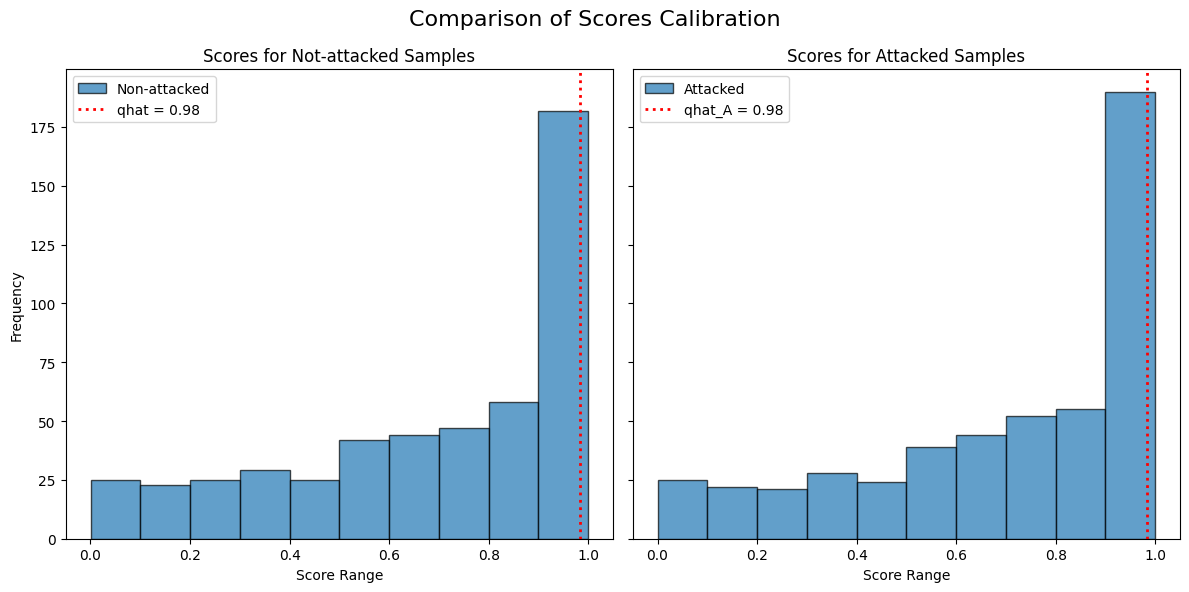

In [13]:
alpha = 0.1

q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl

qhat_VRCP = np.quantile(cl_cs_scores_VRCP, q_level, method='higher')
qhat_A_VRCP = np.quantile(cl_att_scores_VRCP, q_level, method='higher')

print('Classic quantile:', qhat_VRCP)
print('Attacked quantile:', qhat_A_VRCP)


fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axs[0].hist(cl_cs_scores_VRCP, bins=10, edgecolor='black', alpha=0.7, label='Non-attacked')
axs[0].axvline(x=qhat_VRCP, color='red', linestyle='dotted', linewidth=2, label=f'qhat = {qhat_VRCP:.2f}')
axs[0].set_title('Scores for Not-attacked Samples')
axs[0].set_xlabel('Score Range')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(cl_att_scores_VRCP, bins=10, edgecolor='black', alpha=0.7, label='Attacked')
axs[1].axvline(x=qhat_A_VRCP, color='red', linestyle='dotted', linewidth=2, label=f'qhat_A = {qhat_A_VRCP:.2f}')
axs[1].set_title('Scores for Attacked Samples')
axs[1].set_xlabel('Score Range')
axs[1].legend()

fig.suptitle(f'Comparison of Scores Calibration', fontsize=16)
plt.tight_layout()
plt.show()
end_common_time = time.time()
elapsed_common_time = end_common_time - common_time

In [17]:
(103.69*9500)/700

1407.2214285714285

### Vanilla

In [14]:
import time
start_time_vanilla = time.time()
att_conformal_sets_VRCP_vanilla, score_list = compute_CP(ts_att_VRCP, qhat_VRCP, clf_VRCP)
att_coverage_VRCP_vanilla = compute_covergae(ts, att_conformal_sets_VRCP_vanilla)

att_coverage_var_VRCP_vanilla = compute_covergae_std(ts, att_conformal_sets_VRCP_vanilla)
att_sizes_VRCP_vanilla = compute_set_sizes(ts, att_conformal_sets_VRCP_vanilla)

att_size_mean_VRCP_vanilla = mean_conformal_sets(att_conformal_sets_VRCP_vanilla)
att_size_var_VRCP_vanilla = std_conformal_sets(att_conformal_sets_VRCP_vanilla)

#plot_conformal_analysis(ts_att_VRCP, ts, att_sizes_VRCP_vanilla, cl_cs_scores_VRCP, score_list, clf_VRCP,  method = 'lac', steps = 10, dataset_name = "CIFAR10")

end_time_vanilla = time.time()
elapsed_time_vanilla = end_time_vanilla - start_time_vanilla

print(elapsed_time_vanilla + elapsed_common_time)

Computing CP sets: 100%|██████████████████████████████████████████| 200/200 [01:39<00:00,  2.01it/s]

True label is in the conformal set for 179/200 test samples (89.50%).
Coverage std (0.31).
Number of conformal sets with size 1: 11
Number of conformal sets with size 2: 9
Number of conformal sets with size 3: 7
Number of conformal sets with size 4: 10
Number of conformal sets with size 5: 12
Number of conformal sets with size 6: 13
Number of conformal sets with size 7: 7
Number of conformal sets with size 8: 11
Number of conformal sets with size 9: 13
Number of conformal sets with size 10: 10
Number of conformal sets with size 11: 16
Number of conformal sets with size 12: 17
Number of conformal sets with size 13: 19
Number of conformal sets with size 14: 14
Number of conformal sets with size 15: 12
Number of conformal sets with size 16: 9
Number of conformal sets with size 17: 4
Number of conformal sets with size 18: 3
Number of conformal sets with size 19: 1
Number of conformal sets with size 20: 1
Number of conformal sets with size 21: 1
Average set size: 9.555
Std set size: 4.77042

### PERCP

In [16]:
import time
start_time_percp = time.time()
att_conformal_sets_VRCP,att_score_list = compute_CP(ts_att_VRCP, qhat_A_VRCP, clf_VRCP)
att_coverage_VRCP = compute_covergae(ts, att_conformal_sets_VRCP)

att_coverage_var_VRCP = round(compute_covergae_std(ts, att_conformal_sets_VRCP),2)
att_sizes_VRCP = compute_set_sizes(ts, att_conformal_sets_VRCP)

att_size_mean_VRCP = mean_conformal_sets(att_conformal_sets_VRCP)
att_size_var_VRCP = std_conformal_sets(att_conformal_sets_VRCP)

end_time_percp = time.time()
elapsed_time_percp = end_time_percp - start_time_percp

print(elapsed_time_percp + elapsed_common_time)

#plot_conformal_analysis(ts_att_VRCP, ts, att_sizes_VRCP, cl_att_scores_VRCP,att_score_list, clf_VRCP,  method = 'lac', steps = 10, dataset_name = "CIFAR10")

Computing CP sets: 100%|██████████████████████████████████████████| 200/200 [01:39<00:00,  2.01it/s]

True label is in the conformal set for 182/200 test samples (91.00%).
Coverage std (0.29).
Number of conformal sets with size 1: 11
Number of conformal sets with size 2: 9
Number of conformal sets with size 3: 6
Number of conformal sets with size 4: 6
Number of conformal sets with size 5: 16
Number of conformal sets with size 6: 10
Number of conformal sets with size 7: 7
Number of conformal sets with size 8: 12
Number of conformal sets with size 9: 12
Number of conformal sets with size 10: 8
Number of conformal sets with size 11: 13
Number of conformal sets with size 12: 18
Number of conformal sets with size 13: 11
Number of conformal sets with size 14: 20
Number of conformal sets with size 15: 10
Number of conformal sets with size 16: 13
Number of conformal sets with size 17: 7
Number of conformal sets with size 18: 6
Number of conformal sets with size 19: 2
Number of conformal sets with size 20: 2
Number of conformal sets with size 21: 1
Average set size: 10.05
Std set size: 5.045542

### Comparison Table with VRCP and RSCP

In [39]:
n_smooth = 1024 # 1 for linf, 1021 for l2 

base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/VRCP_Results/epsilon_0.02/sigma_model_0/sigma_smooth_0.04/n_smooth_1024/Robust/CNN"

# Loop through each epsilon and read the CSV file
file_path = os.path.join(base_path, "results_CI_noisy.csv")
df = pd.read_csv(file_path)
#print(df)

# Initialize dictionaries to store results
coverage_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
coverage_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}

if os.path.exists(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    for method in ["HPS_vanilla", "HPS_RSCP+", "PTT_HPS_RSCP+","HPS_verif", "HPS_verif_pre"]:
        # Extract the row corresponding to the method
        row = df[df['Method'] == method]

        if not row.empty:
            # Split the coverage and size columns into mean and std
            coverage = row['Coverage_CI'].values[0]
            size = row['Size_CI'].values[0]

            coverage_mean_val, coverage_std_val = map(float, coverage.split("±"))
            size_mean_val, size_std_val = map(float, size.split("±"))

            # Store the values
            coverage_mean[method].append(coverage_mean_val)
            coverage_std[method].append(coverage_std_val)
            size_mean[method].append(size_mean_val)
            size_std[method].append(size_std_val)
else:
    print(f"File not found: {file_path}")

coverage = [coverage_mean["HPS_vanilla"][0],
            coverage_mean["HPS_RSCP+"][0],
            coverage_mean["PTT_HPS_RSCP+"][0],
            coverage_mean["HPS_verif"][0],
            coverage_mean["HPS_verif_pre"][0],
            f"{att_coverage_VRCP / 100:.2f}"]

size = [size_mean["HPS_vanilla"][0],
        size_mean["HPS_RSCP+"][0],
        size_mean["PTT_HPS_RSCP+"][0],
        size_mean["HPS_verif"][0],
        size_mean["HPS_verif_pre"][0],
        att_size_mean_VRCP]

cov_std = [coverage_std["HPS_vanilla"][0],
           coverage_std["HPS_RSCP+"][0],
           coverage_std["PTT_HPS_RSCP+"][0],
           coverage_std["HPS_verif"][0],
           coverage_std["HPS_verif_pre"][0],
           att_coverage_var_VRCP] 

size_std = [size_std["HPS_vanilla"][0],
                 size_std["HPS_RSCP+"][0],
                 size_std["PTT_HPS_RSCP+"][0],
                 size_std["HPS_verif"][0],
                 size_std["HPS_verif_pre"][0],
                 att_size_var_VRCP]  # Example variances for each method

# Format the size column as "size ± variance"
coverage_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(coverage, cov_std)]

size_with_variance = [f"{s} ± {v:.3f}" for s, v in zip(size, size_std)]
# Create DataFrame
df = pd.DataFrame({"Coverage": coverage_with_variance, "Size": size_with_variance}, index=["Vanilla", "RSCP+", "RSCP+(PTT)", "VRCP-I", "VRCP-C", "PERCP"])

# Display table
print(df)

# Save results

# Define the results folder
results_folder = "./Results"

# Ensure the folder exists
os.makedirs(results_folder, exist_ok=True)

# Define the full file path
output_file = os.path.join(results_folder, "Comparison_VRCP_TinyImageNet.csv")

# Save the dataframe to CSV
df.to_csv(output_file, index=True)

print(f"File saved successfully at: {output_file}")

                 Coverage             Size
Vanilla     0.884 ± 0.010   35.912 ± 1.998
RSCP+         1.0 ± 0.000    200.0 ± 0.000
RSCP+(PTT)  0.929 ± 0.031  88.634 ± 47.651
VRCP-I       0.96 ± 0.005   69.572 ± 2.439
VRCP-C      0.974 ± 0.005   77.833 ± 3.422
PERCP        0.91 ± 0.280   11.276 ± 5.708
File saved successfully at: ./Results/Comparison_VRCP_TinyImageNet.csv


### Multiple Attacks: PGD 1,10,100

In [6]:
epsilons_VRCP = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

epsilons = np.linspace(0.1,10.0,50)
extended_epsilons = list(epsilons)# + epsilons_VRCP 

### Check Verifiers' and Randomizers' coverage and size curves

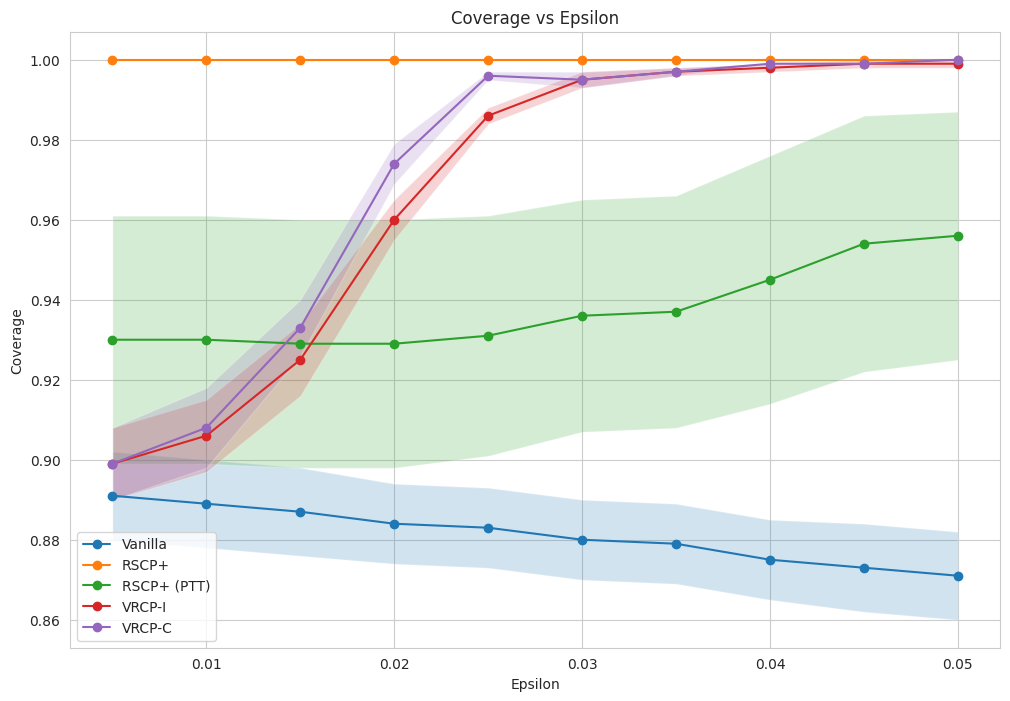

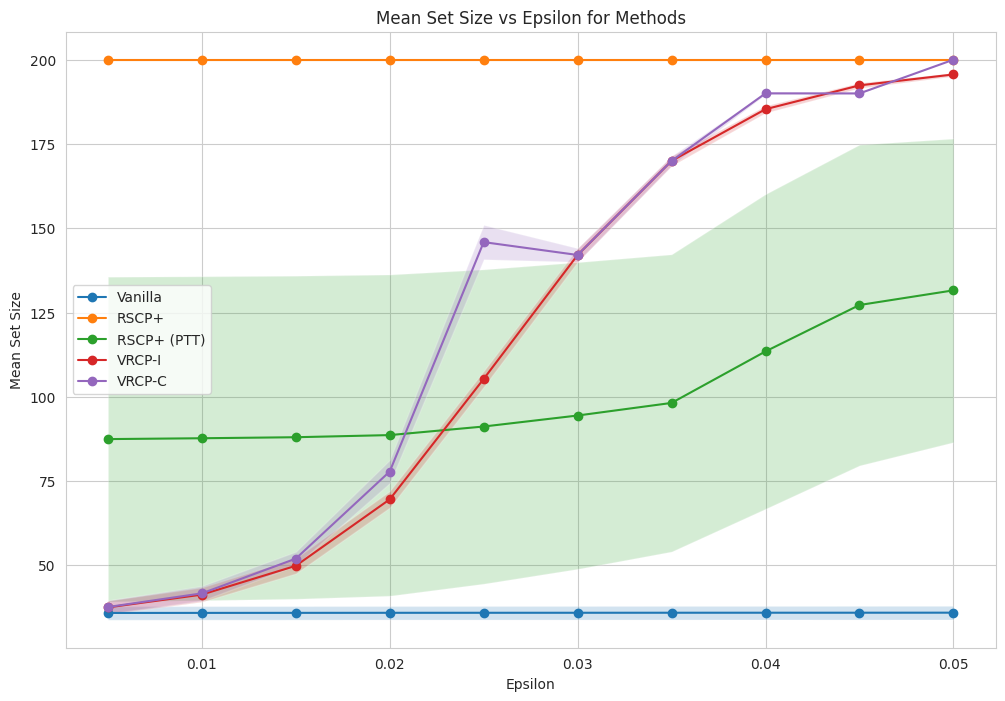

In [38]:
# Define the base path and epsilon values
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/VRCP_Results"
sigma_model = 0
sigma_smooth = 0.01
n_smooth = 1024 # 1 for linf, 1021 for l2

# Initialize dictionaries to store results
coverage_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
coverage_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_mean = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}
size_std = {"HPS_vanilla":[], "HPS_RSCP+":[],"PTT_HPS_RSCP+":[],"HPS_verif": [], "HPS_verif_pre": []}

methods = ["HPS_vanilla", "HPS_RSCP+", "PTT_HPS_RSCP+","HPS_verif", "HPS_verif_pre"]
label_methods = ["Vanilla", "RSCP+", "RSCP+ (PTT)","VRCP-I", "VRCP-C"]
# Loop through each epsilon and read the CSV file
for eps in epsilons_VRCP:
    file_path = os.path.join(
        base_path, f"epsilon_{eps}", f"sigma_model_{sigma_model}", f"sigma_smooth_{eps*2}",
        f"n_smooth_{n_smooth}", "Robust", "CNN", "results_CI_noisy.csv"
)
            
    if os.path.exists(file_path):
        # Read the CSV file
        df = pd.read_csv(file_path)

        for method in methods:
            # Extract the row corresponding to the method
            row = df[df['Method'] == method]
            if not row.empty:
                # Split the coverage and size columns into mean and std
                coverage = row['Coverage_CI'].values[0]
                size = row['Size_CI'].values[0]

                coverage_mean_val, coverage_std_val = map(float, coverage.split("±"))
                size_mean_val, size_std_val = map(float, size.split("±"))

                # Store the values
                coverage_mean[method].append(coverage_mean_val)
                coverage_std[method].append(coverage_std_val)
                size_mean[method].append(size_mean_val)
                size_std[method].append(size_std_val)
    else:
        print(f"File not found: {file_path}")

# Plot Coverage with Shaded Regions
plt.figure(figsize=(12, 8))
for method,label_method in zip(methods, label_methods):
    
    plt.plot(epsilons_VRCP, coverage_mean[method], label=label_method, marker='o')

    plt.fill_between(epsilons_VRCP,
                     np.array(coverage_mean[method]) - np.array(coverage_std[method]),
                     np.array(coverage_mean[method]) + np.array(coverage_std[method]),
                     alpha=0.2)

plt.xlabel("Epsilon")
plt.ylabel("Coverage")
plt.title("Coverage vs Epsilon")
plt.legend()
plt.grid(True)
plt.savefig("coverage_plot.png")
plt.show()

# Plot Size with Shaded Regions
plt.figure(figsize=(12, 8))
for method,label_method in zip(methods, label_methods):
    plt.plot(epsilons_VRCP, size_mean[method], label=f'{label_method}', marker='o')
    plt.fill_between(epsilons_VRCP,
                     np.array(size_mean[method]) - np.array(size_std[method]),
                     np.array(size_mean[method]) + np.array(size_std[method]),
                     alpha=0.2)

plt.xlabel("Epsilon")
plt.ylabel("Mean Set Size")
plt.title("Mean Set Size vs Epsilon for Methods")
plt.legend()
plt.grid(True)
plt.savefig("size_plot.png")
plt.show()


#### With PERCP

In [9]:
import os
import shutil
import csv
import numpy as np

def evaluate_attacks(model_name, norm_name, attack_configs, extended_epsilons, cl, ts, clf, alpha=0.1, base_output_dir="./Results"):
    """
    Evaluate different adversarial attacks on a given model and dataset,
    adapting attack parameters based on different epsilon values.
    """
    n_cl = cl.X.shape[0]

    for eps in extended_epsilons:
        # Adjust attack parameters for each epsilon value
        new_configs = []
        for attack in attack_configs:
            steps = attack["steps"]
            new_attack = attack.copy()
            new_attack["epsilon"] = eps
            new_attack["step_size"] = eps / steps if steps > 0 else attack["step_size"]
            new_configs.append(new_attack)
            
        save_path = os.path.join(base_output_dir, model_name, norm_name,f"eps_{eps:.4f}")
        if os.path.exists(save_path):
            shutil.rmtree(save_path)
        os.makedirs(save_path, exist_ok=True)
        
        csv_file = os.path.join(save_path, "results.csv")
    
        # Run attacks
        cl_att_dict = attack_dataset(cl, clf, new_configs, desc="Running attacks", n_jobs=1)
        ts_att_dict = attack_dataset(ts, clf, new_configs, desc="Running attacks", n_jobs=1)
        
        if isinstance(cl_att_dict,dict):
        
            for attack_type in cl_att_dict.keys():

                cl_att = cl_att_dict[attack_type]
                ts_att = ts_att_dict[attack_type]

                cl_att_scores = compute_score(cl, cl_att, clf_VRCP)

                # Get quantile
                q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl
                qhat_A = np.quantile(cl_att_scores, q_level, method='higher')

                # Conformal sets
                att_conformal_sets,_ = compute_CP(ts_att, qhat_A, clf_VRCP)
                # Compute coverage and variance
                att_coverage = compute_covergae(ts, att_conformal_sets)
                att_coverage_var = compute_covergae_std(ts, att_conformal_sets)

                # Compute mean and variance of set sizes
                att_size_mean = mean_conformal_sets(att_conformal_sets)
                att_size_var = std_conformal_sets(att_conformal_sets) / 10

                # Store results
                results = [
                    {  
                        "attack_type": f"{attack_type}",
                        "coverage": f"{att_coverage:.4f} ± {att_coverage_var:.4f}",
                        "size": f"{att_size_mean:.4f} ± {att_size_var:.4f}"
                    }
                ]

                # Save results to CSV 
                file_exists = os.path.isfile(csv_file)
                with open(csv_file, mode="a", newline="") as file:
                    writer = csv.DictWriter(file, fieldnames=["attack_type", "coverage", "size"])
                    if not file_exists:
                        writer.writeheader()  # Write header only if the file is new
                    writer.writerows(results)

                print(f"Results saved to {csv_file}")
        else:

            attack_type = get_single_attack_key(new_configs[0])

            cl_att = cl_att_dict
            ts_att = ts_att_dict

            cl_att_scores = compute_score(cl, cl_att, clf_VRCP)

            # Get quantile
            q_level = np.ceil((n_cl + 1) * (1 - alpha)) / n_cl
            qhat_A = np.quantile(cl_att_scores, q_level, method='higher')

            # Conformal sets
            att_conformal_sets,_ = compute_CP(ts_att, qhat_A, clf_VRCP)
            # Compute coverage and variance
            att_coverage = compute_covergae(ts, att_conformal_sets)
            att_coverage_var = compute_covergae_std(ts, att_conformal_sets)

            # Compute mean and variance of set sizes
            att_size_mean = mean_conformal_sets(att_conformal_sets)
            att_size_var = std_conformal_sets(att_conformal_sets) / 10


            # Store results
            results = [
                {  
                    "attack_type": f"{attack_type}",
                    "coverage": f"{att_coverage:.4f} ± {att_coverage_var:.4f}",
                    "size": f"{att_size_mean:.4f} ± {att_size_var:.4f}"
                }
            ]

            # Save results to CSV 
            file_exists = os.path.isfile(csv_file)
            with open(csv_file, mode="a", newline="") as file:
                writer = csv.DictWriter(file, fieldnames=["attack_type", "coverage", "size"])
                if not file_exists:
                    writer.writeheader()  # Write header only if the file is new
                writer.writerows(results)

            print(f"Results saved to {csv_file}")


#### With PERCP

In [46]:
epsilons_VRCP = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]

epsilons =np.linspace(0.1,5.0,10)#  np.linspace(0.1,8.0,50) # 
extended_epsilons =  epsilons_VRCP  +  list(epsilons) 

In [ ]:
model_name = "VRCP"
norm_name = "l2"


attack_configs = [
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 1, "distance": "l2", "lb": -1.0, "ub": 1.0},
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 10, "distance": "l2", "lb": -1.0, "ub": 1.0},
    {"attack_type": "PGD", "epsilon": 0.2, "step_size": 0.01, "steps": 100, "distance": "l2", "lb": -1.0, "ub": 1.0}

]

evaluate_attacks(model_name, norm_name, attack_configs, extended_epsilons, cl, ts, clf_VRCP, alpha=0.1, base_output_dir="./Results_101")

Running attacks:   0%|          | 0/500 [00:00<?, ?sample/s]

2025-04-16 22:12:01,487 - py.warnings - WARNING - /home/acarlevaro/.local/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Running attacks:  11%|█▏        | 57/500 [08:13<1:04:18,  8.71s/sample]

In [85]:
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/Results/VRCP/l2"

results_dict = {}

for eps in extended_epsilons:

    file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  

    if  os.path.isfile(file_path):
        file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  
    #else:
    #    file_path = os.path.join(base_path_VRCP_eps, f"eps_{eps:.4f}", "results.csv") 

    config_results_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            # Skip the header or any empty lines
            if line.lower().startswith("attack_type"):
                continue

            # Split each line into columns based on commas
            cols = line.strip().split(',')

            if len(cols) >= 3:
                attack_type = cols[0].strip()
                coverage = cols[1].strip()
                size = cols[2].strip()

                # Extract mean and std values for coverage and size
                coverage_mean, coverage_std = map(float, coverage.split("±"))
                size_mean, size_std = map(float, size.split("±"))


            # Store the results in the dictionary
                config_results_dict[attack_type] = {
                    "coverage_mean": coverage_mean,
                    "coverage_std": coverage_std,
                    "size_mean": size_mean,
                    "size_std": size_std,
                }

            else:
                print(f"File not found: {file_path}")

        results_dict[f"{eps:.4f}"] = config_results_dict
        
print("Data loaded in the dictionary.")
print(" ")
print("The following attacks are available")
print(" ")
attack_names = list(next(iter(results_dict.values())).keys())
print(attack_names)

Data loaded in the dictionary.
 
The following attacks are available
 
['combined', 'PGD_1_l2', 'PGD_10_l2', 'PGD_100_l2']


Data loaded in the dictionary.
 
The following attacks are available
 
['combined', 'PGD_1_l2', 'PGD_10_l2', 'PGD_100_l2']


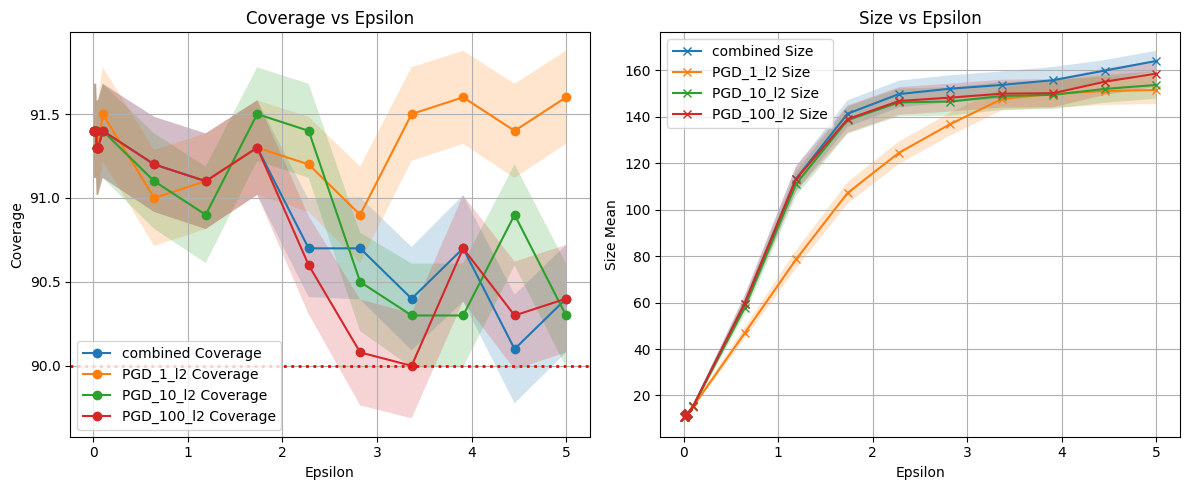

In [47]:
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/Results/VRCP/l2"

results_dict = {}

for eps in extended_epsilons:

    file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  

    if  os.path.isfile(file_path):
        file_path = os.path.join(base_path, f"eps_{eps:.4f}", "results.csv")  
    #else:
    #    file_path = os.path.join(base_path_VRCP_eps, f"eps_{eps:.4f}", "results.csv") 

    config_results_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            # Skip the header or any empty lines
            if line.lower().startswith("attack_type"):
                continue

            # Split each line into columns based on commas
            cols = line.strip().split(',')

            if len(cols) >= 3:
                attack_type = cols[0].strip()
                coverage = cols[1].strip()
                size = cols[2].strip()

                # Extract mean and std values for coverage and size
                coverage_mean, coverage_std = map(float, coverage.split("±"))
                size_mean, size_std = map(float, size.split("±"))


            # Store the results in the dictionary
                config_results_dict[attack_type] = {
                    "coverage_mean": coverage_mean,
                    "coverage_std": coverage_std,
                    "size_mean": size_mean,
                    "size_std": size_std,
                }

            else:
                print(f"File not found: {file_path}")

        results_dict[f"{eps:.4f}"] = config_results_dict
        
print("Data loaded in the dictionary.")
print(" ")
print("The following attacks are available")
print(" ")
attack_names = list(next(iter(results_dict.values())).keys())
print(attack_names)

# Define figure
plt.figure(figsize=(12, 5))

# Set reference value for 1 - alpha
one_minus_alpha_ref = (1 - alpha) * 100  # Convert to percentage

for attack_name in attack_names:

    # Extract coverage and size mean/std for each epsilon
    coverage = [results_dict[f"{eps:.4f}"][attack_name]['coverage_mean'] for eps in extended_epsilons]
    size = [results_dict[f"{eps:.4f}"][attack_name]['size_mean'] for eps in extended_epsilons]

    coverage_std = [results_dict[f"{eps:.4f}"][attack_name]['coverage_std'] for eps in extended_epsilons]
    size_std = [results_dict[f"{eps:.4f}"][attack_name]['size_std'] for eps in extended_epsilons]

    # Convert to NumPy arrays for plotting
    epsilons_np = np.array(extended_epsilons)
    coverage_np, coverage_std_np = np.array(coverage), np.array(coverage_std)
    size_np, size_std_np = np.array(size), np.array(size_std)

    # Plot Coverage vs Epsilon
    plt.subplot(1, 2, 1)
    plt.plot(epsilons_np, coverage_np, label=f'{attack_name} Coverage', marker='o')  # Convert coverage to percentage
    plt.fill_between(epsilons_np, (coverage_np - coverage_std_np), (coverage_np + coverage_std_np), alpha=0.2)

    # Plot Size vs Epsilon
    plt.subplot(1, 2, 2)
    plt.plot(epsilons_np, size_np, label=f'{attack_name} Size', marker='x')
    plt.fill_between(epsilons_np, size_np - size_std_np, size_np + size_std_np, alpha=0.2)

# Add horizontal red line at (1 - α) * 100 on the coverage plot
plt.subplot(1, 2, 1)
plt.axhline(y=one_minus_alpha_ref, color='r', linestyle='dotted', linewidth=2)

# Add label on the y-axis at (1 - α) * 100
plt.subplot(1, 2, 1)
plt.ylabel('Coverage')  # Base y-axis label
#plt.text(x=epsilons_np[0] - (epsilons_np[-1] - epsilons_np[0]) * 0.1,  # Shift left of y-axis
#         y=one_minus_alpha_ref, 
#         s=f'{one_minus_alpha_ref:.1f}', 
#         color='r', fontsize=10, verticalalignment='center', horizontalalignment='right')

# Customize plot appearance
plt.subplot(1, 2, 1)
plt.xlabel('Epsilon')
plt.title('Coverage vs Epsilon')
plt.legend()
#plt.ylim(0.0, 100.0)  # Ensure it's between 0 and 100
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlabel('Epsilon')
plt.ylabel('Size Mean')
plt.title('Size vs Epsilon')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save and show the plot
plt.savefig('coverage_size_plot.png', dpi=300)
plt.show()


2025-04-24 16:57:07,969 - py.warnings - WARNING - /tmp/ipykernel_9297/3072730497.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



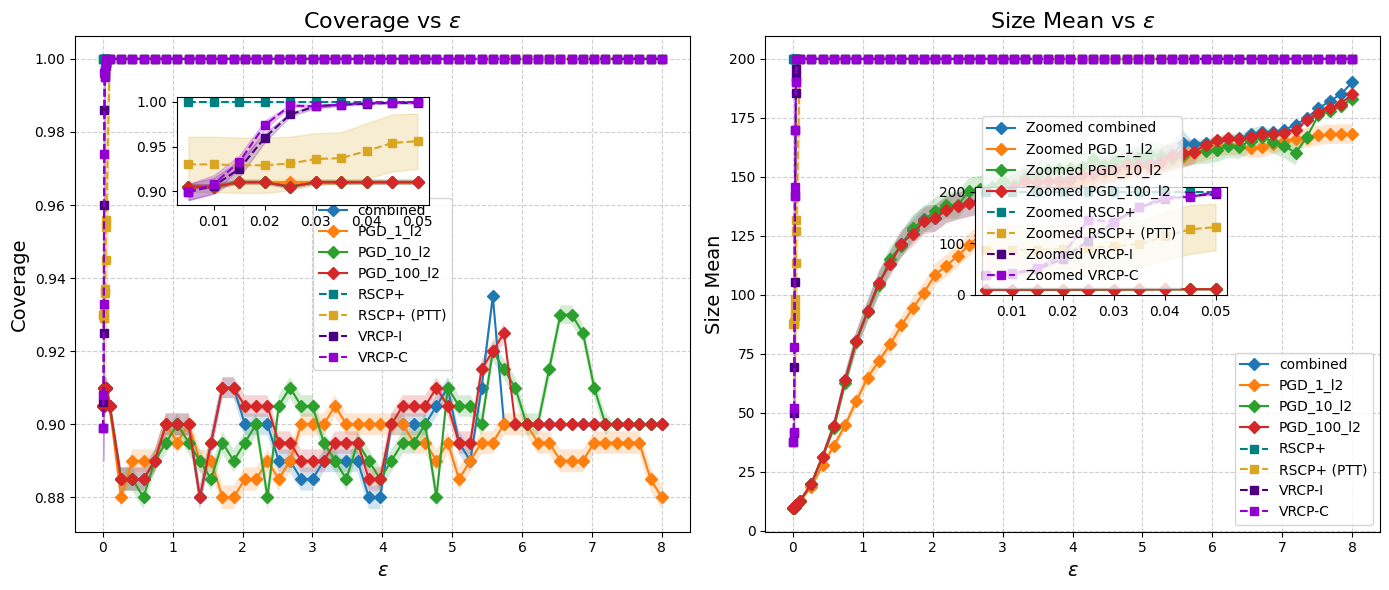

In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define base path and parameters
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/VRCP_Results"
sigma_model = 0
sigma_smooth = 0.01
n_smooth = 1024  # 1 for Linf, 1021 for L2

# Lists for methods and labels
methods = [ "HPS_RSCP+", "PTT_HPS_RSCP+", "HPS_verif", "HPS_verif_pre"]
label_methods = [ "RSCP+", "RSCP+ (PTT)", "VRCP-I", "VRCP-C"]

# Initialize dictionaries for results
coverage_mean, coverage_std = {}, {}
size_mean, size_std = {}, {}

for method in methods:
    coverage_mean[method], coverage_std[method] = [], []
    size_mean[method], size_std[method] = [], []

# Read VRCP results from CSV files
for eps in epsilons_VRCP:
    file_path = os.path.join(base_path, f"epsilon_{eps}", f"sigma_model_{sigma_model}", 
                             f"sigma_smooth_{eps * 2}", f"n_smooth_{n_smooth}", "Robust", "CNN", 
                             "results_CI_noisy.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        for method in methods:
            row = df[df['Method'] == method]
            if not row.empty:
                coverage_mean_val, coverage_std_val = map(float, row['Coverage_CI'].values[0].split("±"))
                size_mean_val, size_std_val = map(float, row['Size_CI'].values[0].split("±"))

                coverage_mean[method].append(coverage_mean_val)
                coverage_std[method].append(coverage_std_val)
                size_mean[method].append(size_mean_val)
                size_std[method].append(size_std_val)
    else:
        print(f"File not found: {file_path}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define zoomed-in inset axes ONCE
ax1_inset = fig.add_axes([0.13, 0.65, 0.18, 0.18])  # Inset for Coverage
ax2_inset = fig.add_axes([0.70, 0.50, 0.18, 0.18])  # Inset for Size

# --- PLOT ATTACK-BASED RESULTS ---
for attack_name in attack_names:
    coverage_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['coverage_mean'] / 100 for eps in extended_epsilons])
    size_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['size_mean'] for eps in extended_epsilons])
    coverage_std_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['coverage_std'] / 100 for eps in extended_epsilons])
    size_std_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['size_std'] for eps in extended_epsilons])

    ax1.plot(extended_epsilons, coverage_np, label=f'{attack_name}', marker='D')
    ax1.fill_between(extended_epsilons, coverage_np - coverage_std_np, coverage_np + coverage_std_np, alpha=0.2)

    ax2.plot(extended_epsilons, size_np, label=f'{attack_name}', marker='D')
    ax2.fill_between(extended_epsilons, size_np - size_std_np, size_np + size_std_np, alpha=0.2)

    # Zoomed-in section (first 10 points)
    zoom_epsilons = extended_epsilons[:10]
    ax1_inset.plot(zoom_epsilons, coverage_np[:10], label=f'Zoomed {attack_name}', marker='D')
    ax1_inset.fill_between(zoom_epsilons, coverage_np[:10] - coverage_std_np[:10], coverage_np[:10] + coverage_std_np[:10], alpha=0.2)

    ax2_inset.plot(zoom_epsilons, size_np[:10], label=f'Zoomed {attack_name}', marker='D')
    ax2_inset.fill_between(zoom_epsilons, size_np[:10] - size_std_np[:10], size_np[:10] + size_std_np[:10], alpha=0.2)

for method in methods:  
    coverage_mean[method] += [1] * (len(extended_epsilons) - len(epsilons_VRCP))
    coverage_std[method] += [0] * (len(extended_epsilons) - len(epsilons_VRCP))  # No variation
    size_mean[method] += [200] * (len(extended_epsilons) - len(epsilons_VRCP))
    size_std[method] += [0] * (len(extended_epsilons) - len(epsilons_VRCP))
    
# Define colors for each method
method_colors = {
    "HPS_RSCP+": "#008080",  # Teal
    "PTT_HPS_RSCP+": "#daa520",  # Gold
    "HPS_verif": "#4b0082",  # Indigo
    "HPS_verif_pre": "#9400D3"  # Dark Violet (instead of Dark Red)
}

# --- PLOT VRCP METHODS ---
for method, label_method in zip(methods, label_methods):
    color = method_colors[method]
    
    coverage_np_VRCP = np.array(coverage_mean[method])
    coverage_std_np_VRCP = np.array(coverage_std[method])
    size_np_VRCP = np.array(size_mean[method])
    size_std_np_VRCP = np.array(size_std[method])

    ax1.plot(extended_epsilons, coverage_np_VRCP, label=label_method, marker='s', linestyle='--', color=color)
    ax1.fill_between(extended_epsilons, coverage_np_VRCP - coverage_std_np_VRCP, coverage_np_VRCP + coverage_std_np_VRCP, alpha=0.2, color=color)

    ax2.plot(extended_epsilons, size_np_VRCP, label=label_method, marker='s', linestyle='--', color=color)
    ax2.fill_between(extended_epsilons, size_np_VRCP - size_std_np_VRCP, size_np_VRCP + size_std_np_VRCP, alpha=0.2, color=color)

    # Zoomed-in VRCP results
    ax1_inset.plot(zoom_epsilons, coverage_np_VRCP[:10], label=f'Zoomed {label_method}', marker='s', linestyle='--', color=color)
    ax1_inset.fill_between(zoom_epsilons, coverage_np_VRCP[:10] - coverage_std_np_VRCP[:10], coverage_np_VRCP[:10] + coverage_std_np_VRCP[:10], alpha=0.2, color=color)

    ax2_inset.plot(zoom_epsilons, size_np_VRCP[:10], label=f'Zoomed {label_method}', marker='s', linestyle='--', color=color)
    ax2_inset.fill_between(zoom_epsilons, size_np_VRCP[:10] - size_std_np_VRCP[:10], size_np_VRCP[:10] + size_std_np_VRCP[:10], alpha=0.2, color=color)

# --- CUSTOMIZATION ---
ax1.set_xlabel(r'$\varepsilon$', fontsize=14)
ax1.set_ylabel('Coverage', fontsize=14)
ax1.set_title(r'Coverage vs $\varepsilon$', fontsize=16)
ax1.legend(fontsize=10, loc='best')
ax1.grid(True, linestyle='--', alpha=0.6)

ax2.set_xlabel(r'$\varepsilon$', fontsize=14)
ax2.set_ylabel('Size Mean', fontsize=14)
ax2.set_title(r'Size Mean vs $\varepsilon$', fontsize=16)
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('coverage_size_combined_with_zoom.png', dpi=300)
plt.legend()
plt.show()


In [67]:
attack_labels = ['Combined', 'PGD_1', 'PGD_10', 'PGD_100']

2025-04-25 21:01:35,063 - py.warnings - WARNING - /tmp/ipykernel_9297/3348914468.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



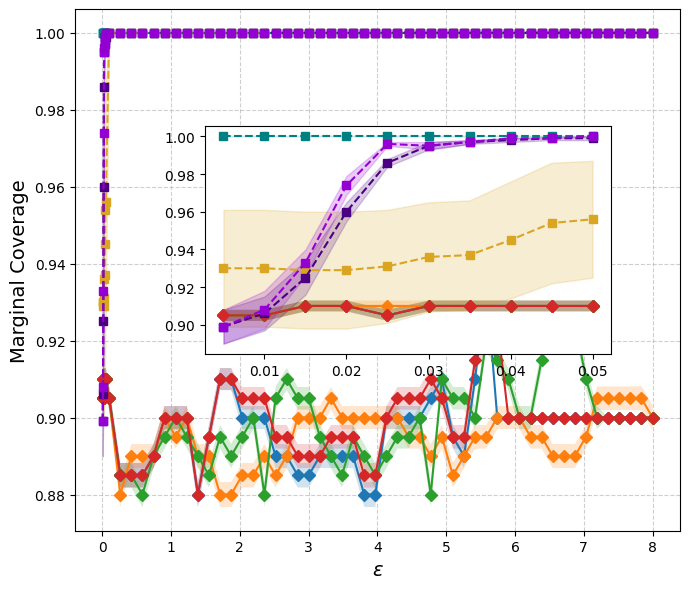

2025-04-25 21:01:35,688 - py.warnings - WARNING - /tmp/ipykernel_9297/3348914468.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



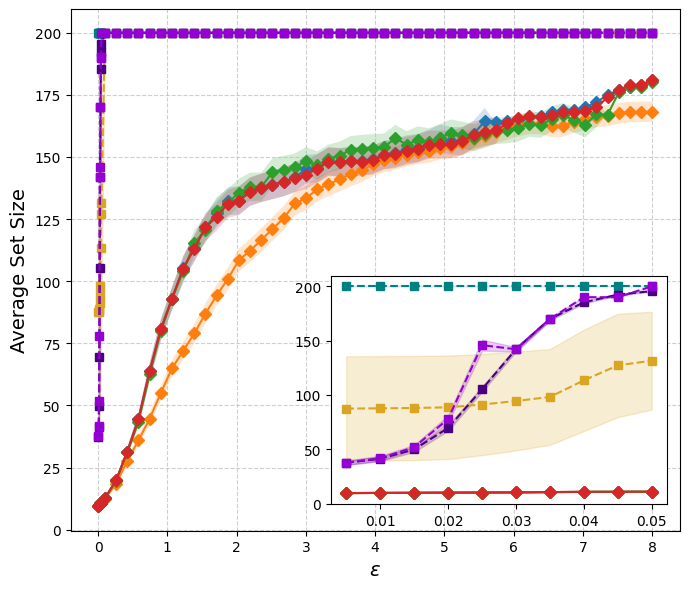

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define base path and parameters
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/VRCP_Results"
sigma_model = 0
sigma_smooth = 0.01
n_smooth = 1024  # 1 for Linf, 1021 for L2

# Lists for methods and labels
methods = [ "HPS_RSCP+", "PTT_HPS_RSCP+", "HPS_verif", "HPS_verif_pre"]
label_methods = [ "RSCP+", "RSCP+ (PTT)", "VRCP-I", "VRCP-C"]

# Initialize dictionaries for results
coverage_mean, coverage_std = {}, {}
size_mean, size_std = {}, {}

for method in methods:
    coverage_mean[method], coverage_std[method] = [], []
    size_mean[method], size_std[method] = [], []

# Read VRCP results from CSV files
for eps in epsilons_VRCP:
    file_path = os.path.join(base_path, f"epsilon_{eps}", f"sigma_model_{sigma_model}", 
                             f"sigma_smooth_{eps * 2}", f"n_smooth_{n_smooth}", "Robust", "CNN", 
                             "results_CI_noisy.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        for method in methods:
            row = df[df['Method'] == method]
            if not row.empty:
                coverage_mean_val, coverage_std_val = map(float, row['Coverage_CI'].values[0].split("±"))
                size_mean_val, size_std_val = map(float, row['Size_CI'].values[0].split("±"))

                coverage_mean[method].append(coverage_mean_val)
                coverage_std[method].append(coverage_std_val)
                size_mean[method].append(size_mean_val)
                size_std[method].append(size_std_val)
    else:
        print(f"File not found: {file_path}")

# --- PLOTTING 1 --- Coverage Plot
fig1, ax1 = plt.subplots(figsize=(7, 6))

# Define zoomed-in inset axes ONCE
ax1_inset = fig1.add_axes([0.30, 0.40, 0.58, 0.38])  # Inset for Coverage

# --- PLOT ATTACK-BASED RESULTS ---
for attack_name in attack_names:
    coverage_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['coverage_mean'] / 100 for eps in extended_epsilons])
    coverage_std_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['coverage_std'] / 100 for eps in extended_epsilons])

    ax1.plot(extended_epsilons, coverage_np, label=f'{attack_name}', marker='D')
    ax1.fill_between(extended_epsilons, coverage_np - coverage_std_np, coverage_np + coverage_std_np, alpha=0.2)

    # Zoomed-in section (first 10 points)
    zoom_epsilons = extended_epsilons[:10]
    ax1_inset.plot(zoom_epsilons, coverage_np[:10], label=f'Zoomed {attack_name}', marker='D')
    ax1_inset.fill_between(zoom_epsilons, coverage_np[:10] - coverage_std_np[:10], coverage_np[:10] + coverage_std_np[:10], alpha=0.2)

for method in methods:  
    coverage_mean[method] += [1] * (len(extended_epsilons) - len(epsilons_VRCP))
    coverage_std[method] += [0] * (len(extended_epsilons) - len(epsilons_VRCP))  # No variation
    
# Define colors for each method
method_colors = {
    "HPS_RSCP+": "#008080",  # Teal
    "PTT_HPS_RSCP+": "#daa520",  # Gold
    "HPS_verif": "#4b0082",  # Indigo
    "HPS_verif_pre": "#9400D3"  # Dark Violet (instead of Dark Red)
}

# --- PLOT VRCP METHODS ---
for method, label_method in zip(methods, label_methods):
    color = method_colors[method]
    
    coverage_np_VRCP = np.array(coverage_mean[method])
    coverage_std_np_VRCP = np.array(coverage_std[method])

    ax1.plot(extended_epsilons, coverage_np_VRCP, label=label_method, marker='s', linestyle='--', color=color)
    ax1.fill_between(extended_epsilons, coverage_np_VRCP - coverage_std_np_VRCP, coverage_np_VRCP + coverage_std_np_VRCP, alpha=0.2, color=color)

    # Zoomed-in VRCP results
    ax1_inset.plot(zoom_epsilons, coverage_np_VRCP[:10], label=f'Zoomed {label_method}', marker='s', linestyle='--', color=color)
    ax1_inset.fill_between(zoom_epsilons, coverage_np_VRCP[:10] - coverage_std_np_VRCP[:10], coverage_np_VRCP[:10] + coverage_std_np_VRCP[:10], alpha=0.2, color=color)

# --- CUSTOMIZATION ---
ax1.set_xlabel(r'$\varepsilon$', fontsize=14)
ax1.set_ylabel('Marginal Coverage', fontsize=14)
#ax1.set_title(r'Coverage vs $\varepsilon$', fontsize=16)
#ax1.legend(fontsize=10, loc='best')
ax1.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('Coverag_TinyImageNet.pdf', dpi=300)
plt.show()

# --- PLOTTING 2 --- Size Plot
fig2, ax2 = plt.subplots(figsize=(7, 6))

# Define zoomed-in inset axes ONCE
ax2_inset = fig2.add_axes([0.48, 0.15, 0.48, 0.38])  # Inset for Size

# --- PLOT ATTACK-BASED RESULTS ---
for attack_name in attack_names:
    size_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['size_mean'] for eps in extended_epsilons])
    size_std_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['size_std'] for eps in extended_epsilons])

    ax2.plot(extended_epsilons, size_np, label=f'{attack_name}', marker='D')
    ax2.fill_between(extended_epsilons, size_np - size_std_np, size_np + size_std_np, alpha=0.2)

    # Zoomed-in section (first 10 points)
    zoom_epsilons = extended_epsilons[:10]
    ax2_inset.plot(zoom_epsilons, size_np[:10], label=f'Zoomed {attack_name}', marker='D')
    ax2_inset.fill_between(zoom_epsilons, size_np[:10] - size_std_np[:10], size_np[:10] + size_std_np[:10], alpha=0.2)

for method in methods:  
    size_mean[method] += [200] * (len(extended_epsilons) - len(epsilons_VRCP))
    size_std[method] += [0] * (len(extended_epsilons) - len(epsilons_VRCP))  # No variation
    
# --- PLOT VRCP METHODS ---
for method, label_method in zip(methods, label_methods):
    color = method_colors[method]
    
    size_np_VRCP = np.array(size_mean[method])
    size_std_np_VRCP = np.array(size_std[method])

    ax2.plot(extended_epsilons, size_np_VRCP, label=label_method, marker='s', linestyle='--', color=color)
    ax2.fill_between(extended_epsilons, size_np_VRCP - size_std_np_VRCP, size_np_VRCP + size_std_np_VRCP, alpha=0.2, color=color)

    # Zoomed-in VRCP results
    ax2_inset.plot(zoom_epsilons, size_np_VRCP[:10], label=f'Zoomed {label_method}', marker='s', linestyle='--', color=color)
    ax2_inset.fill_between(zoom_epsilons, size_np_VRCP[:10] - size_std_np_VRCP[:10], size_np_VRCP[:10] + size_std_np_VRCP[:10], alpha=0.2, color=color)

# --- CUSTOMIZATION ---
ax2.set_xlabel(r'$\varepsilon$', fontsize=14)
ax2.set_ylabel('Average Set Size', fontsize=14)
#ax2.set_title(r'Size Mean vs $\varepsilon$', fontsize=16)
#ax2.legend(fontsize=10, loc='best')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('Averag_Size_TinyImageNet.pdf', dpi=300)
plt.show()


2025-04-25 21:32:31,604 - py.warnings - WARNING - /tmp/ipykernel_9297/3127591474.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



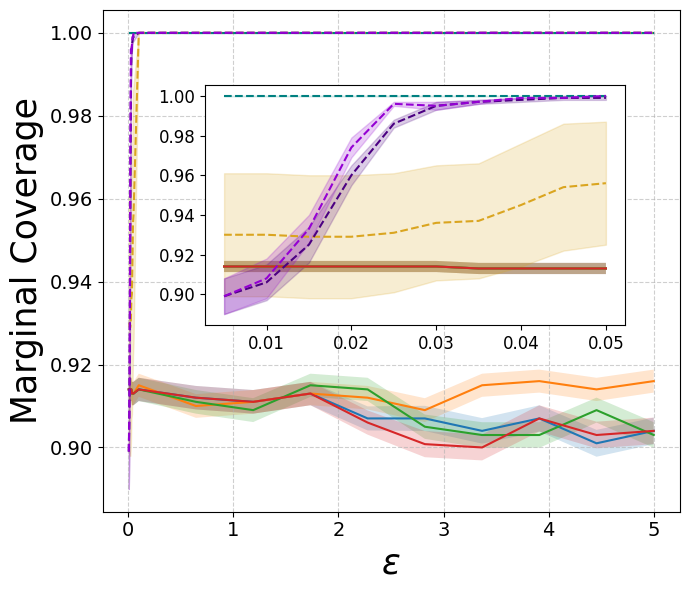

2025-04-25 21:32:32,152 - py.warnings - WARNING - /tmp/ipykernel_9297/3127591474.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



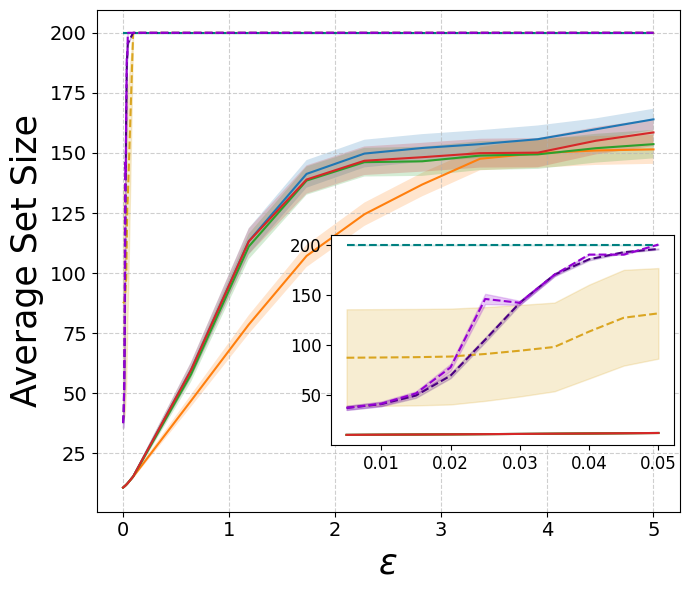

In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define base path and parameters
base_path = "/home/acarlevaro/Sources/albi/Adversarial_CP_V3/InyImageNet/VRCP_Results"
sigma_model = 0
sigma_smooth = 0.01
n_smooth = 1024  # 1 for Linf, 1021 for L2

# Lists for methods and labels
methods = [ "HPS_RSCP+", "PTT_HPS_RSCP+", "HPS_verif", "HPS_verif_pre"]
label_methods = [ "RSCP+", "RSCP+ (PTT)", "VRCP-I", "VRCP-C"]

# Initialize dictionaries for results
coverage_mean, coverage_std = {}, {}
size_mean, size_std = {}, {}

for method in methods:
    coverage_mean[method], coverage_std[method] = [], []
    size_mean[method], size_std[method] = [], []

# Read VRCP results from CSV files
for eps in epsilons_VRCP:
    file_path = os.path.join(base_path, f"epsilon_{eps}", f"sigma_model_{sigma_model}", 
                             f"sigma_smooth_{eps * 2}", f"n_smooth_{n_smooth}", "Robust", "CNN", 
                             "results_CI_noisy.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        for method in methods:
            row = df[df['Method'] == method]
            if not row.empty:
                coverage_mean_val, coverage_std_val = map(float, row['Coverage_CI'].values[0].split("±"))
                size_mean_val, size_std_val = map(float, row['Size_CI'].values[0].split("±"))

                coverage_mean[method].append(coverage_mean_val)
                coverage_std[method].append(coverage_std_val)
                size_mean[method].append(size_mean_val)
                size_std[method].append(size_std_val)
    else:
        print(f"File not found: {file_path}")

# --- PLOTTING 1 --- Coverage Plot
fig1, ax1 = plt.subplots(figsize=(7, 6))

# Define zoomed-in inset axes ONCE
ax1_inset = fig1.add_axes([0.30, 0.45, 0.60, 0.40])  # Inset for Coverage

# --- PLOT ATTACK-BASED RESULTS ---
for attack_name in attack_names:
    coverage_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['coverage_mean'] / 100 for eps in extended_epsilons])
    coverage_std_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['coverage_std'] / 100 for eps in extended_epsilons])

    ax1.plot(extended_epsilons, coverage_np, label=f'{attack_name}')
    ax1.fill_between(extended_epsilons, coverage_np - coverage_std_np, coverage_np + coverage_std_np, alpha=0.2)

    # Zoomed-in section (first 10 points)
    zoom_epsilons = extended_epsilons[:10]
    ax1_inset.plot(zoom_epsilons, coverage_np[:10], label=f'Zoomed {attack_name}')
    ax1_inset.fill_between(zoom_epsilons, coverage_np[:10] - coverage_std_np[:10], coverage_np[:10] + coverage_std_np[:10], alpha=0.2)

for method in methods:  
    coverage_mean[method] += [1] * (len(extended_epsilons) - len(epsilons_VRCP))
    coverage_std[method] += [0] * (len(extended_epsilons) - len(epsilons_VRCP))  # No variation
    
# Define colors for each method
method_colors = {
    "HPS_RSCP+": "#008080",  # Teal
    "PTT_HPS_RSCP+": "#daa520",  # Gold
    "HPS_verif": "#4b0082",  # Indigo
    "HPS_verif_pre": "#9400D3"  # Dark Violet (instead of Dark Red)
}

# --- PLOT VRCP METHODS ---
for method, label_method in zip(methods, label_methods):
    color = method_colors[method]
    
    coverage_np_VRCP = np.array(coverage_mean[method])
    coverage_std_np_VRCP = np.array(coverage_std[method])

    ax1.plot(extended_epsilons, coverage_np_VRCP, label=label_method, linestyle='--', color=color)
    ax1.fill_between(extended_epsilons, coverage_np_VRCP - coverage_std_np_VRCP, coverage_np_VRCP + coverage_std_np_VRCP, alpha=0.2, color=color)

    # Zoomed-in VRCP results
    ax1_inset.plot(zoom_epsilons, coverage_np_VRCP[:10], label=f'Zoomed {label_method}', linestyle='--', color=color)
    ax1_inset.fill_between(zoom_epsilons, coverage_np_VRCP[:10] - coverage_std_np_VRCP[:10], coverage_np_VRCP[:10] + coverage_std_np_VRCP[:10], alpha=0.2, color=color)
    
    ax1_inset.tick_params(axis='both', which='major', labelsize=12) 
    ax1.tick_params(axis='both', which='major', labelsize=14) 
# --- CUSTOMIZATION ---
ax1.set_xlabel(r'$\varepsilon$', fontsize=25)
ax1.set_ylabel('Marginal Coverage', fontsize=25)
#ax1.set_title(r'Coverage vs $\varepsilon$', fontsize=16)
#ax1.legend(fontsize=10, loc='best')
ax1.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('Coverag_TinyImageNet.pdf', dpi=300)
plt.show()

# --- PLOTTING 2 --- Size Plot
fig2, ax2 = plt.subplots(figsize=(7, 6))

# Define zoomed-in inset axes ONCE
ax2_inset = fig2.add_axes([0.48, 0.25, 0.49, 0.35])  # Inset for Size

# --- PLOT ATTACK-BASED RESULTS ---
for attack_name in attack_names:
    size_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['size_mean'] for eps in extended_epsilons])
    size_std_np = np.array([results_dict[f"{eps:.4f}"][attack_name]['size_std'] for eps in extended_epsilons])

    ax2.plot(extended_epsilons, size_np, label=f'{attack_name}')
    ax2.fill_between(extended_epsilons, size_np - size_std_np, size_np + size_std_np, alpha=0.2)

    # Zoomed-in section (first 10 points)
    zoom_epsilons = extended_epsilons[:10]
    ax2_inset.plot(zoom_epsilons, size_np[:10], label=f'Zoomed {attack_name}')
    ax2_inset.fill_between(zoom_epsilons, size_np[:10] - size_std_np[:10], size_np[:10] + size_std_np[:10], alpha=0.2)

for method in methods:  
    size_mean[method] += [200] * (len(extended_epsilons) - len(epsilons_VRCP))
    size_std[method] += [0] * (len(extended_epsilons) - len(epsilons_VRCP))  # No variation
    
# --- PLOT VRCP METHODS ---
for method, label_method in zip(methods, label_methods):
    color = method_colors[method]
    
    size_np_VRCP = np.array(size_mean[method])
    size_std_np_VRCP = np.array(size_std[method])

    ax2.plot(extended_epsilons, size_np_VRCP, label=label_method, linestyle='--', color=color)
    ax2.fill_between(extended_epsilons, size_np_VRCP - size_std_np_VRCP, size_np_VRCP + size_std_np_VRCP, alpha=0.2, color=color)

    # Zoomed-in VRCP results
    ax2_inset.plot(zoom_epsilons, size_np_VRCP[:10], label=f'Zoomed {label_method}', linestyle='--', color=color)
    ax2_inset.fill_between(zoom_epsilons, size_np_VRCP[:10] - size_std_np_VRCP[:10], size_np_VRCP[:10] + size_std_np_VRCP[:10], alpha=0.2, color=color)
    ax2_inset.tick_params(axis='both', which='major', labelsize=12) 
    ax2.tick_params(axis='both', which='major', labelsize=14) 

# --- CUSTOMIZATION ---
ax2.set_xlabel(r'$\varepsilon$', fontsize=25)
ax2.set_ylabel('Average Set Size', fontsize=25)
#ax2.set_title(r'Size Mean vs $\varepsilon$', fontsize=16)
#ax2.legend(fontsize=10, loc='best')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('Averag_Size_TinyImageNet.pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()
